# CS7643 - Final Project

In [20]:
# built-in
import os
from collections import Counter
# public
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})
# private
from config import Config, InstrConfig, ILConfig
from src.utils import dataloader, helpers
from src.models.instructions_generator_model import InstructionsGeneratorModel
from src.trainer import instructions_generator_trainer
from src.models.imitation_learning_model import ImitationLearningModel
from src.trainer import imitation_learning_trainer
from src.models.imitation_learning_generative_language_model import ImitationLearningGenerativeLanguageModel
from src.trainer import imitation_learning_generative_language_trainer
from src.gamer import game_env

%load_ext autoreload 
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialization

In [2]:
config = Config()
helpers.set_seed(config.random_seed)

# Data

## Load Data

In [3]:
# train size 202831
# unique number of instructions 35921
data = dataloader.load_pkl(workdir=config.DATA_PATH)

In [4]:
train_states, train_inventories, train_actions, train_goals, train_instructions, all_instructions = data

In [5]:
# remove invalid sample where train instruction is None
invalid_index = set([i for i, _ in enumerate(train_instructions) if not _])
print(len(invalid_index))

34


In [6]:
valid_index = [i for i, _ in enumerate(train_instructions) if _]
print(len(valid_index))
train_states = np.array(train_states)[valid_index].tolist()
train_inventories = np.array(train_inventories)[valid_index].tolist()
train_actions = np.array(train_actions)[valid_index].tolist()
train_instructions = np.array(train_instructions)[valid_index].tolist()

202797


In [7]:
# action size
c = Counter()
c.update(train_actions)
print(c)
len(c)

Counter({'up': 37842, 'left': 37539, 'down': 37211, 'right': 35955, 'grab': 14583, 'craft': 13064, 'mine': 11701, 'toggle_switch': 7504, 'stop': 7398})


9

## Build Vocab

In [8]:
# will download glove vector cache for the first run
vocab, vocab_weights = dataloader.generate_vocab(
    all_instructions
    , config.device
    , workdir=config.DATA_PATH
    , cache=config.glove_cache)

Total vocabulary size: 212


---

# Instructions Generator

## Generate Dataset

In [9]:
instr_config = InstrConfig()
instr_config.random_seed = 123
print(instr_config.validation_split)
print(instr_config.random_seed)

0.2
123


In [10]:
dataset = dataloader.CraftingDataset(
    instr_config.embedding_dim
    , train_states
    , train_inventories
    , train_actions
    , train_goals
    , train_instructions
    , vocab
    , cache=instr_config.glove_cache)

embedding loaded
one hot loaded
actions loaded
goals loaded
done loading dataset


In [11]:
min([len(d[-1]) for d in dataset])

3

In [12]:
instr_config.dataset_size = len(dataset)

## Split Dataset

In [13]:
indices = list(range(instr_config.dataset_size))
split = int(np.floor(instr_config.validation_split * instr_config.dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

## Initialize Data Loader

In [14]:
train_data_loader = DataLoader(
  dataset,
  batch_size=instr_config.batch_size,
  num_workers=instr_config.num_workers,
  pin_memory=True,
  sampler=train_sampler,
  collate_fn=dataloader.collate_fn)

validation_data_loader = DataLoader(
  dataset,
  batch_size=instr_config.batch_size,
  num_workers=instr_config.num_workers,
  pin_memory=True,
  sampler=valid_sampler,
  collate_fn=dataloader.collate_fn)

## Setup Training

In [15]:
model = InstructionsGeneratorModel(
    instr_config.device
    , vocab
    , instr_config.embedding_dim
    , vocab_weights
).to(instr_config.device)
train = instructions_generator_trainer.train
validate = instructions_generator_trainer.validate
# CE Loss
criterion = torch.nn.CrossEntropyLoss()
# Adam
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=instr_config.learning_rate)
# Log
writer = SummaryWriter() if instr_config.summary_writer else None

In [16]:
instr_config.teacher_forcing_rate = 0

## GO

In [17]:
train_losses, train_accuracy = [], []
valid_losses, valid_accuracy = [], []

best_valid_loss, best_valid_bleu, best_valid_tk_acc = float('inf'), float('inf'), float('inf')
valid_epoch, best_epoch = 0, None

for epoch in range(instr_config.epochs):
    # train
    loss, bleu, tk_acc = train(
        instr_config.device,
        epoch,
        train_data_loader,
        model,
        optimizer,
        criterion,
        parameters,
        vocab,
        instr_config,
        summary_writer=writer)
    print('Overall Epoch: %d, train loss: %.3f, train bleu: %.3f, train token acc: %.3f' % (epoch, loss, bleu, tk_acc))
    train_losses.append(loss)
    train_accuracy.append(tk_acc)
    # valid
    loss, bleu, tk_acc = validate(
        instr_config.device,
        epoch,
        validation_data_loader,
        model,
        criterion,
        vocab,
        summary_writer=writer)
    valid_losses.append(loss)
    valid_accuracy.append(tk_acc)
    print('Overall Epoch: %d, valid loss: %.3f, valid bleu: %.3f, valid token acc: %.3f' % (epoch, loss, bleu, tk_acc))
    # early stopping
    if loss <= best_valid_loss:
        best_valid_loss, best_valid_bleu, best_valid_tk_acc = loss, bleu, tk_acc
        valid_epoch, best_epoch = 0, epoch
        torch.save(model.state_dict(), instr_config.SAVE_PATH)
        print('Best Epoch: %d, valid loss: %.3f, valid bleu: %.3f, valid token acc: %.3f' \
              % (best_epoch, best_valid_loss, best_valid_bleu, best_valid_tk_acc))
        print('Trained model saved at ', instr_config.SAVE_PATH)
    else:
        valid_epoch += 1
        if valid_epoch >= instr_config.valid_patience:
            break

Epoch: 0, train loss: 5.001, train bleu: 0.460, train token acc: 0.517:   6%| | 


KeyboardInterrupt: 

In [18]:
print(train_losses, train_accuracy)
print(valid_losses, valid_accuracy)

[] []
[] []


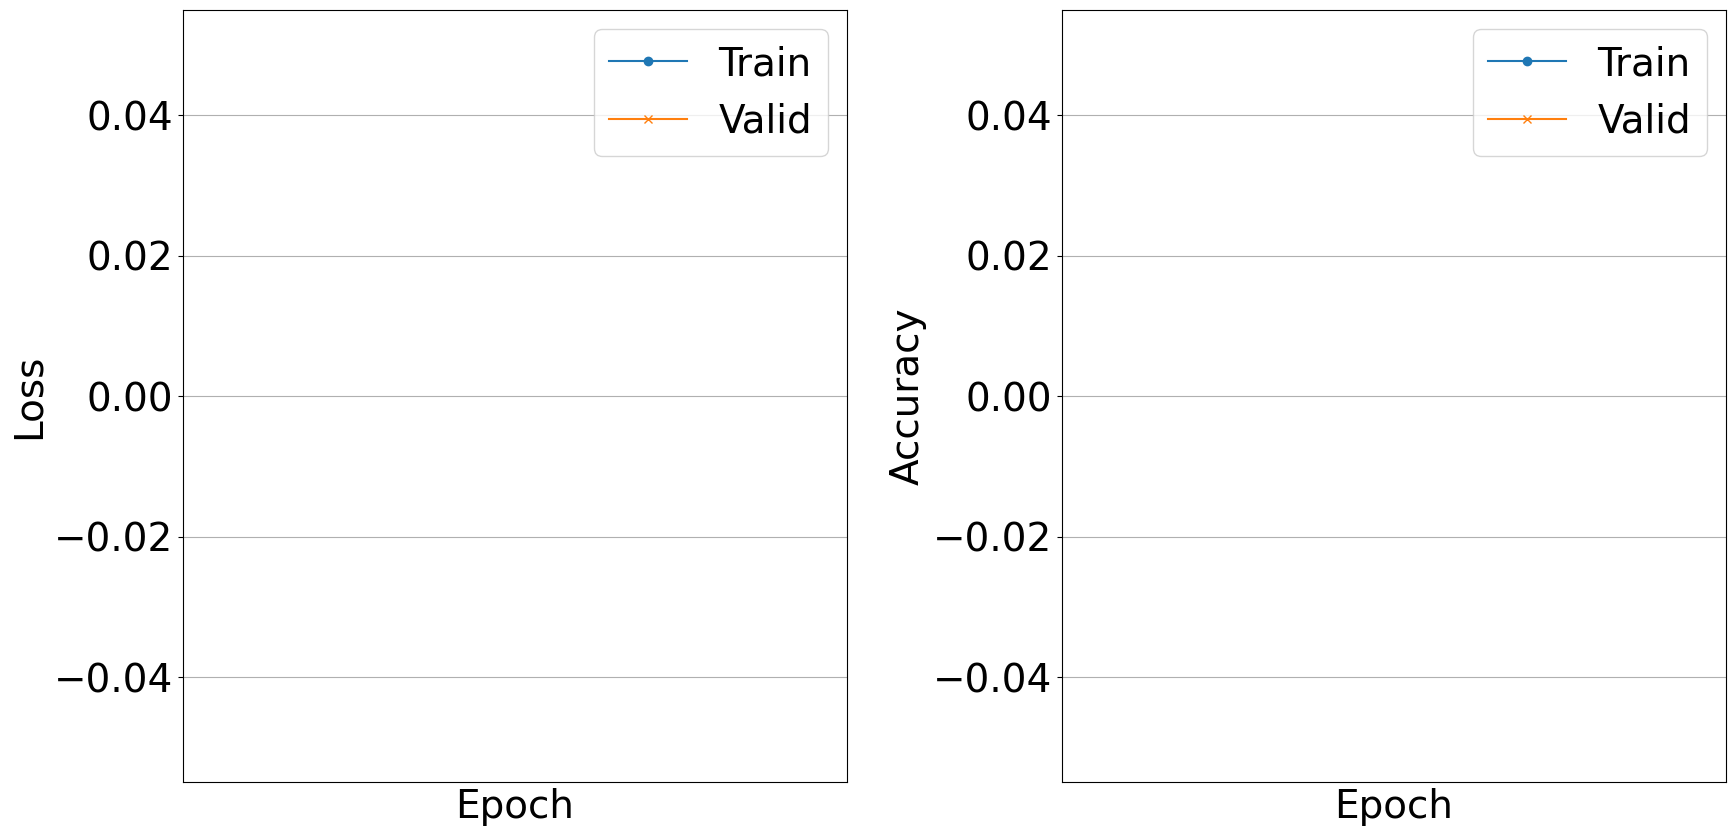

In [22]:
# visualization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9), dpi=100)
plot1 = axes[0].plot(range(len(train_losses)), train_losses, marker='o', label='Train')
plot1 = axes[0].plot(range(len(train_losses)), valid_losses, marker='x', label='Valid')

plot2 = axes[1].plot(range(len(train_accuracy)), train_accuracy, marker='o', label='Train')
plot2 = axes[1].plot(range(len(train_accuracy)), valid_accuracy, marker='x', label='Valid')

ylabels = ['Loss', 'Accuracy']
for i in range(2):
    axes[i].legend()
    axes[i].set_xticks([y for y in range(len(train_losses))])
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_xlabel('Epoch')
    axes[i].yaxis.grid(True)

plt.tight_layout()
plt.savefig(
    os.path.join(instr_config.RESOURCE_PATH, 'img', 'instructions_generator_0_5_teacher_forcing.png')
    , dpi=100
    , bbox_inches='tight')

---

# Reinforcement Learning (RL) - Pre-training

## Common Imitation Learning (IL) Setup

### Initialization

In [11]:
il_config = ILConfig()
il_config.random_seed = 123
il_config.validation_split = 0.2
il_config.epochs = 20

### Generate Dataset

In [12]:
dataset = dataloader.CraftingDataset(
  il_config.embedding_dim,
  train_states,
  train_inventories,
  train_actions,
  train_goals,
  train_instructions,
  vocab,
  cache=config.glove_cache)

embedding loaded
one hot loaded
actions loaded
goals loaded
done loading dataset


In [13]:
il_config.dataset_size = len(dataset)

### Split Dataset

In [14]:
indices = list(range(il_config.dataset_size))
split = int(np.floor(il_config.validation_split * il_config.dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

### Initialize Data Loader

In [15]:
train_data_loader = DataLoader(
  dataset,
  batch_size=il_config.batch_size,
  num_workers=il_config.num_workers,
  pin_memory=True,
  sampler=train_sampler,
  collate_fn=dataloader.collate_fn)

validation_data_loader = DataLoader(
  dataset,
  batch_size=il_config.batch_size,
  num_workers=il_config.num_workers,
  pin_memory=True,
  sampler=valid_sampler,
  collate_fn=dataloader.collate_fn)

## Vanilla Imitation Learning

### Setup

In [17]:
model = ImitationLearningModel(il_config).to(il_config.device)
train = imitation_learning_trainer.train
validate = imitation_learning_trainer.validate
validate_game = imitation_learning_trainer.validate_game
# CE Loss
criterion = torch.nn.CrossEntropyLoss()
# Adam
optimizer = torch.optim.Adam(model.parameters(), lr=il_config.learning_rate)
# Log
writer = SummaryWriter() if il_config.summary_writer else None

### GO

In [18]:
train_losses, train_accuracy = [], []
valid_losses, valid_accuracy = [], []

best_valid_loss, best_valid_acc, best_valid_reward= float('inf'), float('inf'), float('inf')
valid_epoch, best_epoch = 0, None

for epoch in range(il_config.epochs):
    # train
    loss, accuracy = train(epoch, train_data_loader, model, optimizer, criterion, il_config, summary_writer=writer)
    train_losses.append(loss)
    train_accuracy.append(accuracy)
    print('Overall Epoch: %d, train loss: %.3f, train accuracy: %.3f' % (epoch, loss, accuracy))
    # valid
    loss, accuracy = validate(epoch, validation_data_loader, model, criterion, il_config, summary_writer=writer)
    valid_losses.append(loss)
    valid_accuracy.append(accuracy)
    # valid game
    sum_rewards = validate_game(epoch, model, il_config, cache=config.glove_cache)
    print('Overall Epoch: %d, valid loss: %.3f, valid accuracy: %.3f, valid sum rewards: %.3f' % (epoch, loss, accuracy, sum_rewards))
    # early stopping
    if loss <= best_valid_loss:
        best_valid_loss, best_valid_acc, best_valid_reward = loss, accuracy, sum_rewards
        valid_epoch, best_epoch = 0, epoch
        torch.save(model.state_dict(), il_config.SAVE_PATH)
        print('Best Epoch: %d, valid loss: %.3f, valid accuracy: %.3f, valid sum rewards: %.3f' \
              % (best_epoch, best_valid_loss, best_valid_acc, best_valid_reward))
        print('Trained model saved at ', il_config.SAVE_PATH)
    else:
        valid_epoch += 1
        if valid_epoch >= il_config.valid_patience:
            break

Epoch: 0, train loss: 1.050, train accuracy: 0.597: 100%|██████████| 2535/2535 [00:42<00:00, 60.19it/s]


Overall Epoch: 0, train loss: 1.275, train accuracy: 0.508


Epoch: 0, valid loss: 1.171, valid accuracy: 0.553: 100%|██████████| 634/634 [00:07<00:00, 86.74it/s]
100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


Overall Epoch: 0, valid loss: 1.046, valid accuracy: 0.611, valid sum rewards: 2.000
Best Epoch: 0, valid loss: 1.046, valid accuracy: 0.611, valid sum rewards: 2.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


  0%|          | 0/2535 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [23]:
print(train_losses, train_accuracy)
print(valid_losses, valid_accuracy)

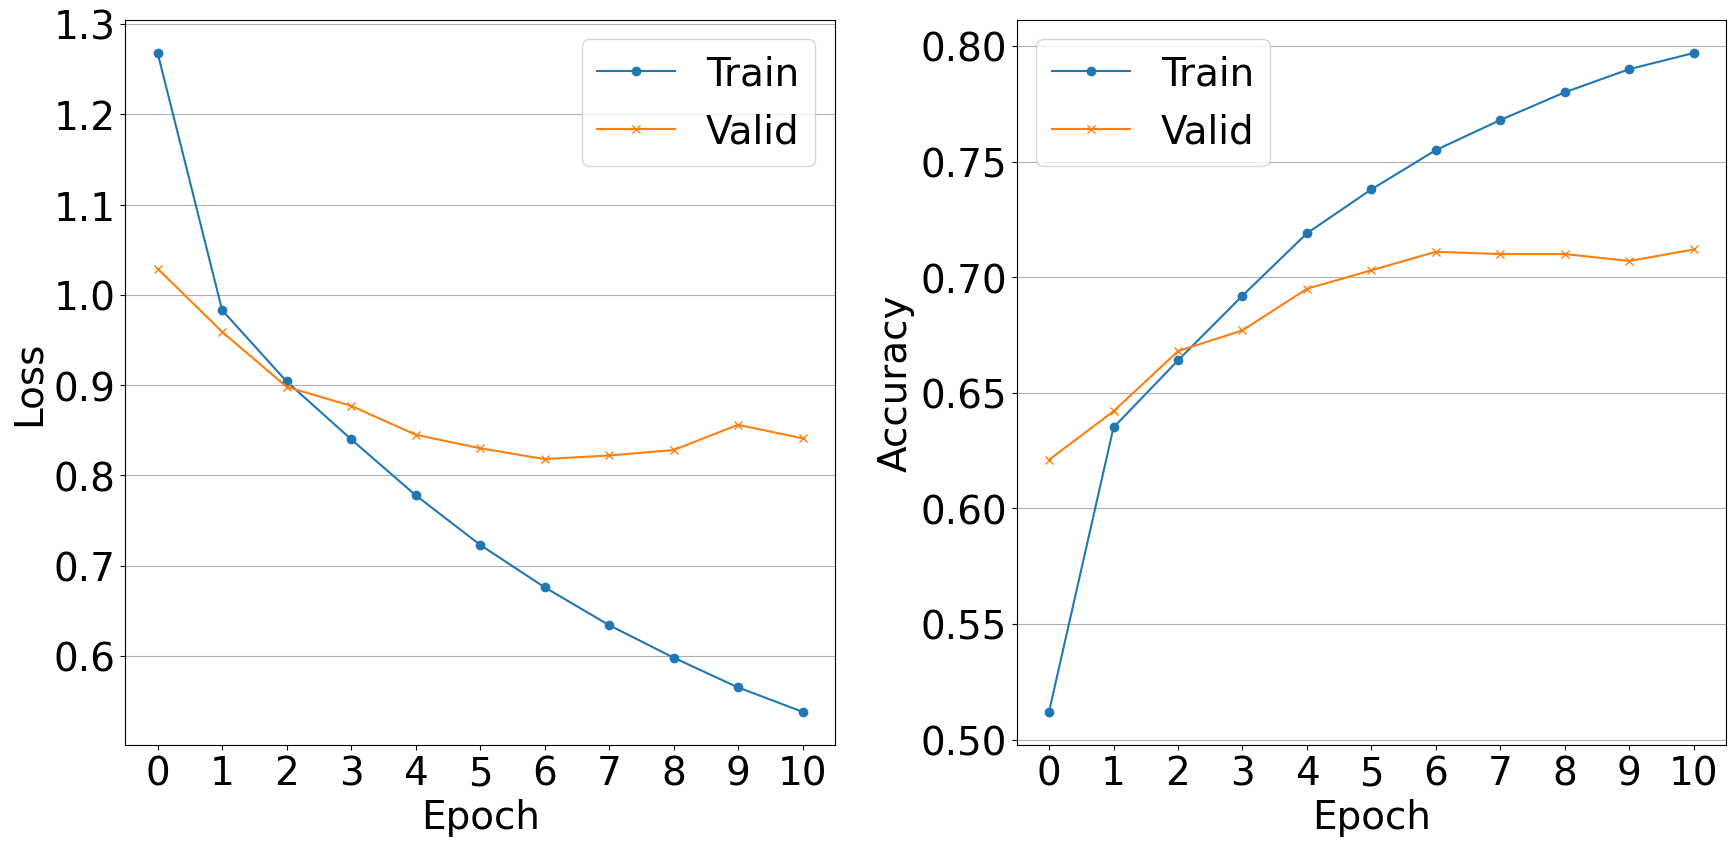

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9), dpi=100)
plot1 = axes[0].plot(range(len(train_losses)), train_losses, marker='o', label='Train')
plot1 = axes[0].plot(range(len(train_losses)), valid_losses, marker='x', label='Valid')

plot2 = axes[1].plot(range(len(train_accuracy)), train_accuracy, marker='o', label='Train')
plot2 = axes[1].plot(range(len(train_accuracy)), valid_accuracy, marker='x', label='Valid')

ylabels = ['Loss', 'Accuracy']
for i in range(2):
    axes[i].legend()
    axes[i].set_xticks([y for y in range(len(train_losses))])
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_xlabel('Epoch')
    axes[i].yaxis.grid(True)
    
plt.tight_layout()
plt.savefig(os.path.join(il_config.RESOURCE_PATH, 'img', 'IL.png'), dpi=100, bbox_inches='tight')

## IL with Instructions

### Set up

In [42]:
il_config.random_seed = 321
il_config.validation_split = 0.2

In [43]:
train = imitation_learning_generative_language_trainer.train
validate = imitation_learning_generative_language_trainer.validate
validate_game = imitation_learning_generative_language_trainer.validate_game

instr_config = InstrConfig()
lstm_model = InstructionsGeneratorModel(
    instr_config.device
    , vocab
    , instr_config.embedding_dim
    , vocab_weights
).to(instr_config.device)
il_model = ImitationLearningGenerativeLanguageModel(il_config).to(il_config.device)

# CE Loss
lstm_criterion = torch.nn.CrossEntropyLoss()
il_criterion = torch.nn.CrossEntropyLoss()

# Adam
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=il_config.learning_rate)
il_optimizer = torch.optim.Adam(il_model.parameters(), lr=il_config.learning_rate)

# Log
writer = SummaryWriter() if il_config.summary_writer else None

### Go

In [44]:
best_valid_loss, best_valid_acc, best_valid_reward= float('inf'), float('inf'), float('inf')
valid_epoch, best_epoch = 0, None

train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

for epoch in range(il_config.epochs):
    # train
    loss, accuracy, lstm_loss, bleu, token_acc = train(epoch, train_data_loader, lstm_model, lstm_optimizer, lstm_criterion, il_model, il_optimizer, il_criterion, vocab, il_config, summary_writer=writer)
    print('Overall Epoch: %d, train loss: %.3f, train accuracy: %.3f, train lstm loss: %.3f, train bleu: %.3f, train token acc: %.3f' % (epoch, loss, accuracy, lstm_loss, bleu, token_acc))
    train_losses.append(loss)
    train_accuracy.append(accuracy)
    # valid
    loss, accuracy, lstm_loss, bleu, token_acc = validate(epoch, validation_data_loader, lstm_model, lstm_criterion, il_model, il_criterion, vocab, il_config, summary_writer=writer)
    valid_losses.append(loss)
    valid_accuracy.append(accuracy)
    # valid game
    sum_rewards = validate_game(epoch, lstm_model, il_model, il_config, cache=config.glove_cache)
    print('Overall Epoch: %d, valid loss: %.3f, valid accuracy: %.3f, valid lstm loss: %.3f, valid bleu: %.3f, valid token acc: %.3f, valid sum rewards: %.3f' % (epoch, loss, accuracy, lstm_loss, bleu, token_acc, sum_rewards))
    # early stopping
    if loss <= best_valid_loss:
        best_valid_loss, best_valid_acc, best_valid_reward = loss, accuracy, sum_rewards
        valid_epoch, best_epoch = 0, epoch
        torch.save(il_model.state_dict(), il_config.SAVE_PATH)
        torch.save(lstm_model.state_dict(), il_config.LSTM_SAVE_PATH)
        print('Best Epoch: %d, valid loss: %.3f, valid accuracy: %.3f, valid sum rewards: %.3f' \
              % (best_epoch, best_valid_loss, best_valid_acc, best_valid_reward))
        print('Trained model saved at ', il_config.SAVE_PATH)
    else:
        valid_epoch += 1
        if valid_epoch >= il_config.valid_patience:
            break

Epoch: 0, train action loss: 0.976, train lang loss: 4.846, train action acc: 0.597, train bleu: 0.480, train token acc: 0.517: 100%|██████████| 2535/2535 [04:43<00:00,  8.93it/s]


Overall Epoch: 0, train loss: 1.224, train accuracy: 0.529, train lstm loss: 3.997, train bleu: 0.474, train token acc: 0.572


Epoch: 0, valid action loss: 1.073, valid lang loss: 4.218, valid action acc: 0.532, valid bleu: 0.413, valid token acc: 0.491: 100%|██████████| 634/634 [00:58<00:00, 10.82it/s]
100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Overall Epoch: 0, valid loss: 1.006, valid accuracy: 0.627, valid lstm loss: 4.277, valid bleu: 0.427, valid token acc: 0.490, valid sum rewards: 0.000
Best Epoch: 0, valid loss: 1.006, valid accuracy: 0.627, valid sum rewards: 0.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 1, train action loss: 1.186, train lang loss: 4.696, train action acc: 0.629, train bleu: 0.463, train token acc: 0.516: 100%|██████████| 2535/2535 [04:53<00:00,  8.65it/s]


Overall Epoch: 1, train loss: 0.939, train accuracy: 0.654, train lstm loss: 3.705, train bleu: 0.487, train token acc: 0.591


Epoch: 1, valid action loss: 0.941, valid lang loss: 4.274, valid action acc: 0.511, valid bleu: 0.399, valid token acc: 0.459: 100%|██████████| 634/634 [00:59<00:00, 10.71it/s]
100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Overall Epoch: 1, valid loss: 0.930, valid accuracy: 0.654, valid lstm loss: 4.158, valid bleu: 0.404, valid token acc: 0.473, valid sum rewards: 0.000
Best Epoch: 1, valid loss: 0.930, valid accuracy: 0.654, valid sum rewards: 0.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 2, train action loss: 0.988, train lang loss: 2.706, train action acc: 0.645, train bleu: 0.549, train token acc: 0.690: 100%|██████████| 2535/2535 [04:57<00:00,  8.52it/s]


Overall Epoch: 2, train loss: 0.847, train accuracy: 0.694, train lstm loss: 3.627, train bleu: 0.497, train token acc: 0.600


Epoch: 2, valid action loss: 1.097, valid lang loss: 3.883, valid action acc: 0.553, valid bleu: 0.455, valid token acc: 0.535: 100%|██████████| 634/634 [00:58<00:00, 10.87it/s]
100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


Overall Epoch: 2, valid loss: 0.866, valid accuracy: 0.691, valid lstm loss: 4.179, valid bleu: 0.428, valid token acc: 0.493, valid sum rewards: 0.000
Best Epoch: 2, valid loss: 0.866, valid accuracy: 0.691, valid sum rewards: 0.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 3, train action loss: 0.544, train lang loss: 2.402, train action acc: 0.774, train bleu: 0.545, train token acc: 0.719: 100%|██████████| 2535/2535 [04:55<00:00,  8.58it/s]


Overall Epoch: 3, train loss: 0.760, train accuracy: 0.734, train lstm loss: 3.568, train bleu: 0.502, train token acc: 0.606


Epoch: 3, valid action loss: 0.794, valid lang loss: 4.309, valid action acc: 0.745, valid bleu: 0.415, valid token acc: 0.480: 100%|██████████| 634/634 [00:58<00:00, 10.91it/s]
100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


Overall Epoch: 3, valid loss: 0.839, valid accuracy: 0.708, valid lstm loss: 4.155, valid bleu: 0.424, valid token acc: 0.490, valid sum rewards: 0.000
Best Epoch: 3, valid loss: 0.839, valid accuracy: 0.708, valid sum rewards: 0.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 4, train action loss: 0.664, train lang loss: 2.534, train action acc: 0.710, train bleu: 0.593, train token acc: 0.739: 100%|██████████| 2535/2535 [04:54<00:00,  8.61it/s]


Overall Epoch: 4, train loss: 0.693, train accuracy: 0.759, train lstm loss: 3.542, train bleu: 0.506, train token acc: 0.610


Epoch: 4, valid action loss: 0.883, valid lang loss: 4.085, valid action acc: 0.702, valid bleu: 0.480, valid token acc: 0.539: 100%|██████████| 634/634 [00:55<00:00, 11.37it/s]
100%|██████████| 15/15 [00:22<00:00,  1.50s/it]


Overall Epoch: 4, valid loss: 0.806, valid accuracy: 0.718, valid lstm loss: 4.278, valid bleu: 0.456, valid token acc: 0.514, valid sum rewards: 0.000
Best Epoch: 4, valid loss: 0.806, valid accuracy: 0.718, valid sum rewards: 0.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 5, train action loss: 0.735, train lang loss: 2.314, train action acc: 0.774, train bleu: 0.579, train token acc: 0.737: 100%|██████████| 2535/2535 [04:55<00:00,  8.58it/s]


Overall Epoch: 5, train loss: 0.637, train accuracy: 0.778, train lstm loss: 3.429, train bleu: 0.513, train token acc: 0.620


Epoch: 5, valid action loss: 0.797, valid lang loss: 4.116, valid action acc: 0.660, valid bleu: 0.427, valid token acc: 0.480: 100%|██████████| 634/634 [00:58<00:00, 10.90it/s]
100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


Overall Epoch: 5, valid loss: 0.830, valid accuracy: 0.719, valid lstm loss: 4.163, valid bleu: 0.425, valid token acc: 0.489, valid sum rewards: 0.000


Epoch: 6, train action loss: 0.512, train lang loss: 2.315, train action acc: 0.774, train bleu: 0.573, train token acc: 0.726: 100%|██████████| 2535/2535 [04:56<00:00,  8.54it/s]


Overall Epoch: 6, train loss: 0.593, train accuracy: 0.791, train lstm loss: 3.495, train bleu: 0.512, train token acc: 0.614


Epoch: 6, valid action loss: 0.750, valid lang loss: 4.353, valid action acc: 0.766, valid bleu: 0.473, valid token acc: 0.521: 100%|██████████| 634/634 [00:54<00:00, 11.72it/s]
100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


Overall Epoch: 6, valid loss: 0.814, valid accuracy: 0.715, valid lstm loss: 4.324, valid bleu: 0.463, valid token acc: 0.518, valid sum rewards: 0.000


Epoch: 7, train action loss: 0.730, train lang loss: 4.633, train action acc: 0.742, train bleu: 0.430, train token acc: 0.497: 100%|██████████| 2535/2535 [04:55<00:00,  8.57it/s]


Overall Epoch: 7, train loss: 0.555, train accuracy: 0.803, train lstm loss: 3.432, train bleu: 0.516, train token acc: 0.620


Epoch: 7, valid action loss: 0.900, valid lang loss: 4.334, valid action acc: 0.681, valid bleu: 0.495, valid token acc: 0.560: 100%|██████████| 634/634 [00:55<00:00, 11.42it/s]
100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


Overall Epoch: 7, valid loss: 0.802, valid accuracy: 0.725, valid lstm loss: 4.276, valid bleu: 0.460, valid token acc: 0.517, valid sum rewards: 2.000
Best Epoch: 7, valid loss: 0.802, valid accuracy: 0.725, valid sum rewards: 2.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 8, train action loss: 0.461, train lang loss: 2.355, train action acc: 0.806, train bleu: 0.614, train token acc: 0.761: 100%|██████████| 2535/2535 [04:57<00:00,  8.53it/s]


Overall Epoch: 8, train loss: 0.521, train accuracy: 0.814, train lstm loss: 3.458, train bleu: 0.517, train token acc: 0.619


Epoch: 8, valid action loss: 0.737, valid lang loss: 4.342, valid action acc: 0.809, valid bleu: 0.488, valid token acc: 0.544: 100%|██████████| 634/634 [00:57<00:00, 11.10it/s]
100%|██████████| 15/15 [00:27<00:00,  1.82s/it]


Overall Epoch: 8, valid loss: 0.810, valid accuracy: 0.725, valid lstm loss: 4.184, valid bleu: 0.435, valid token acc: 0.499, valid sum rewards: 0.000


Epoch: 9, train action loss: 0.550, train lang loss: 2.210, train action acc: 0.790, train bleu: 0.587, train token acc: 0.746: 100%|██████████| 2535/2535 [04:58<00:00,  8.50it/s]


Overall Epoch: 9, train loss: 0.488, train accuracy: 0.825, train lstm loss: 3.443, train bleu: 0.517, train token acc: 0.619


Epoch: 9, valid action loss: 0.767, valid lang loss: 4.340, valid action acc: 0.638, valid bleu: 0.442, valid token acc: 0.512: 100%|██████████| 634/634 [00:55<00:00, 11.37it/s]
100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


Overall Epoch: 9, valid loss: 0.835, valid accuracy: 0.727, valid lstm loss: 4.303, valid bleu: 0.465, valid token acc: 0.519, valid sum rewards: 0.000


Epoch: 10, train action loss: 0.549, train lang loss: 4.642, train action acc: 0.823, train bleu: 0.480, train token acc: 0.514: 100%|██████████| 2535/2535 [04:56<00:00,  8.54it/s]


Overall Epoch: 10, train loss: 0.460, train accuracy: 0.834, train lstm loss: 3.404, train bleu: 0.521, train token acc: 0.624


Epoch: 10, valid action loss: 1.261, valid lang loss: 4.399, valid action acc: 0.574, valid bleu: 0.379, valid token acc: 0.453: 100%|██████████| 634/634 [00:56<00:00, 11.20it/s]
100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


Overall Epoch: 10, valid loss: 0.839, valid accuracy: 0.722, valid lstm loss: 4.227, valid bleu: 0.444, valid token acc: 0.504, valid sum rewards: 0.000


Epoch: 11, train action loss: 0.684, train lang loss: 2.364, train action acc: 0.790, train bleu: 0.571, train token acc: 0.724: 100%|██████████| 2535/2535 [04:58<00:00,  8.49it/s]


Overall Epoch: 11, train loss: 0.440, train accuracy: 0.839, train lstm loss: 3.441, train bleu: 0.518, train token acc: 0.620


Epoch: 11, valid action loss: 0.951, valid lang loss: 4.198, valid action acc: 0.745, valid bleu: 0.452, valid token acc: 0.504: 100%|██████████| 634/634 [00:57<00:00, 11.04it/s]
100%|██████████| 15/15 [00:24<00:00,  1.67s/it]

Overall Epoch: 11, valid loss: 0.846, valid accuracy: 0.726, valid lstm loss: 4.191, valid bleu: 0.432, valid token acc: 0.495, valid sum rewards: 0.000


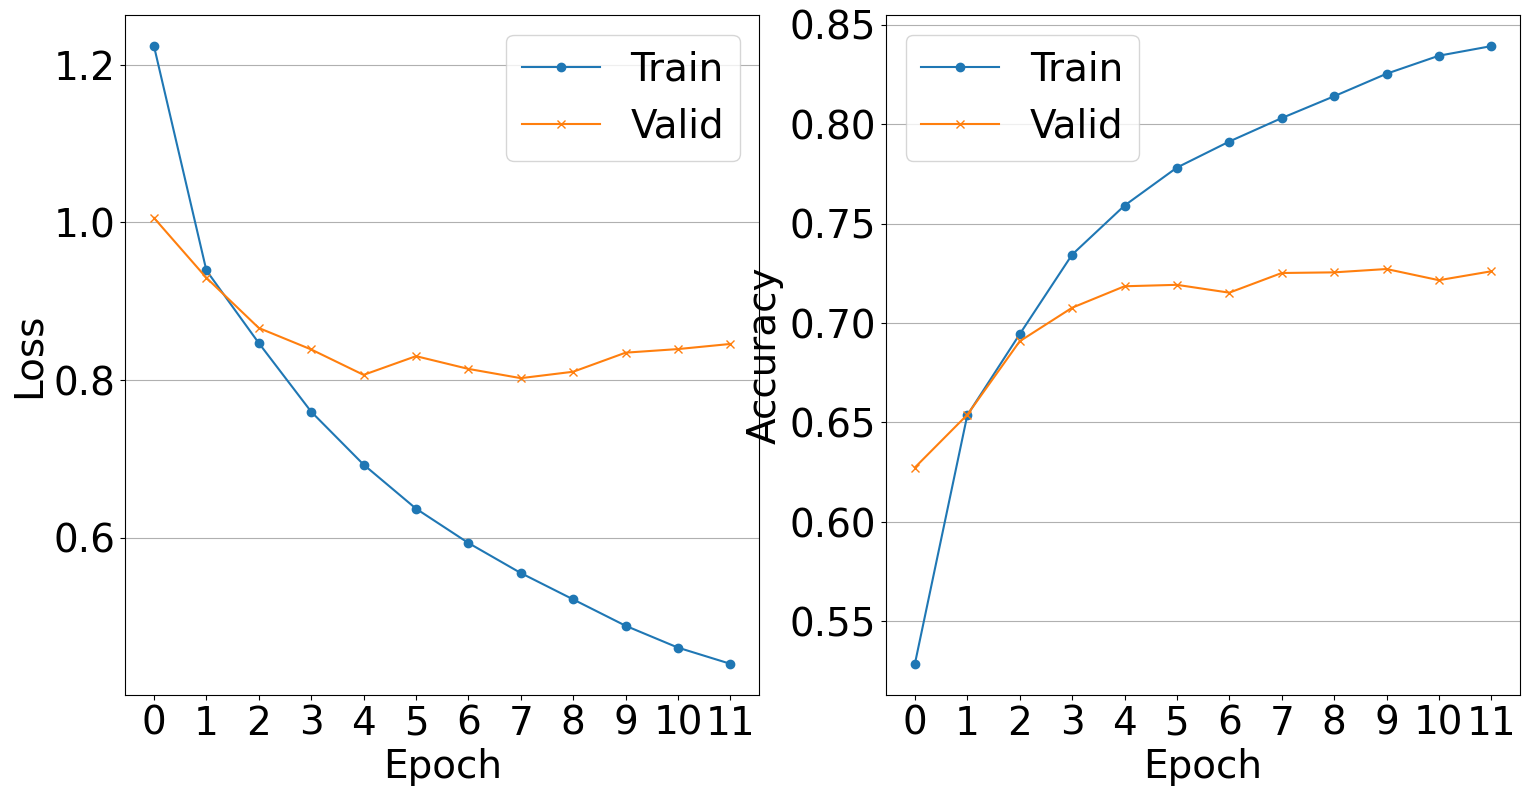

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9), dpi=100)
plot1 = axes[0].plot(range(len(train_losses)), train_losses, marker='o', label='Train')
plot1 = axes[0].plot(range(len(train_losses)), valid_losses, marker='x', label='Valid')

plot2 = axes[1].plot(range(len(train_accuracy)), train_accuracy, marker='o', label='Train')
plot2 = axes[1].plot(range(len(train_accuracy)), valid_accuracy, marker='x', label='Valid')

ylabels = ['Loss', 'Accuracy']
for i in range(2):
    axes[i].legend()
    axes[i].set_xticks([y for y in range(len(train_losses))])
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_xlabel('Epoch')
    axes[i].yaxis.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(il_config.RESOURCE_PATH, 'img', 'il_lstm.png'), dpi=100, bbox_inches='tight')

In [51]:
il_config.game_file_name = 'length3task.yaml'
il_config.game_file_name

'length3task.yaml'

In [47]:
il_model.load_state_dict(torch.load(il_config.SAVE_PATH))
lstm_model.load_state_dict(torch.load(il_config.LSTM_SAVE_PATH))

<All keys matched successfully>

In [52]:
sum_rewards = validate_game(1, lstm_model, il_model, il_config, cache=config.glove_cache)
print(sum_rewards)
sum_rewards = validate_game(1, lstm_model, il_model, il_config, cache=config.glove_cache)
print(sum_rewards)
sum_rewards = validate_game(1, lstm_model, il_model, il_config, cache=config.glove_cache)
print(sum_rewards)

100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


0


100%|██████████| 15/15 [00:22<00:00,  1.53s/it]


1


100%|██████████| 15/15 [00:22<00:00,  1.53s/it]

1


---